In [1]:
# This is an example of the comparison of images using the HOG technique
#
# Prepared by Juan D. Soler (soler@mpia.de)

import sys
sys.path.append('../')
from astrohog2d import *
from statests import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits

from scipy import ndimage

In [2]:
# Load the images that you want to compare
# astroHOG assumes that the cubes are spatially aligned and are reprojected into the same grid

hdul = fits.open('../data/testimage1.fits')
image1=hdul[0].data
hdul.close()
hdul = fits.open('../data/testimage2.fits')
image2=hdul[0].data
hdul.close()

# In case the images are in png format
#image1 = scipy.ndimage.imread('../data/image.001.png', flatten=True)
#image2 = scipy.ndimage.imread('../data/image.002.png', flatten=True)

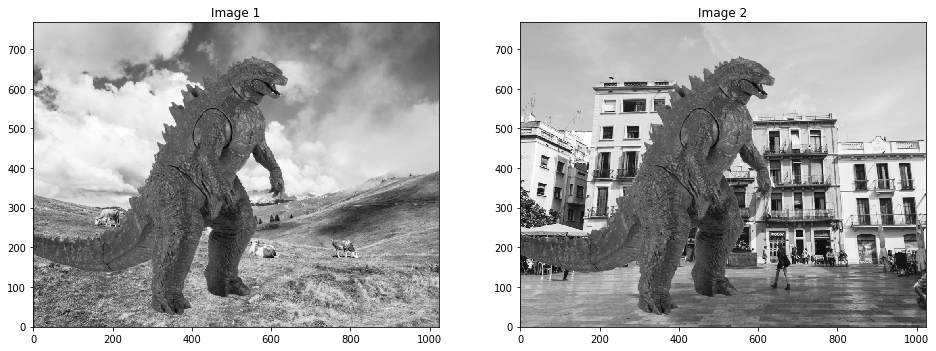

In [3]:
fig, ax = plt.subplots(1,2, figsize=(16., 12.))
ax[0].imshow(image1, origin='lower', cmap='Greys_r')
ax[0].set_title('Image 1')
ax[1].imshow(image2, origin='lower', cmap='Greys_r')
ax[1].set_title('Image 2')
plt.show()

In [4]:
# Here you select the size of your derivative kernel in pixels
ksz=3

In [5]:
# Here I define the masks for both images
# For the sake of simplicity, I'm only masking the edges
sz1=np.shape(image1)
mask1=1.+0.*image1
mask1[0:ksz,:]=0.
mask1[sz1[0]-1-ksz:sz1[0]-1,:]=0.
mask1[:,0:ksz]=0.
mask1[:,sz1[1]-1-ksz:sz1[1]-1]=0.
sz2=np.shape(image2)
mask2=1.+0.*image2
mask2[0:ksz,:]=0.
mask2[sz2[0]-1-ksz:sz2[0]-1,:]=0.
mask2[:,0:ksz]=0.
mask2[:,sz2[1]-1-ksz:sz2[1]-1]=0.

In [7]:
# Calculate the relative orientation angles using the tools in the astroHOG package
circstats, corrframe, smoothframe1, smoothframe2 = HOGcorr_imaLITE(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2)

In [8]:
# Print the correlation statistics obtained by astrohog
print('Mean resultant vector (r)        ', circstats[0])
print('Rayleigh statistic (Z)           ', circstats[1])
print('Projected Rayleigh statistic (V) ', circstats[2])
print('Rayleigh statistic (ii)          ', circstats[5], '+/-', circstats[6])
print('Mean angle                       ', circstats[7])
print('Alignment measure (AM)           ', circstats[8])

Mean resultant vector (r)         0.23206322822325973
Rayleigh statistic (Z)            41774.89896018124
Projected Rayleigh statistic (V)  180010.02995140632
Rayleigh statistic (ii)           289.0415852523875 +/- 0.8799587658530699
Mean angle                        0.003774469738757452
Alignment measure (AM)            0.44203705


In [9]:
# For the sake of illustration, here we calculate the gradients that underlie astroHOG
dI1dx=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[0,1], mode='nearest')
dI1dy=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[1,0], mode='nearest')
normgrad1=np.sqrt(dI1dx**2+dI1dy**2)
udI1dx=dI1dx/normgrad1
udI1dy=dI1dy/normgrad1
psi1=np.arctan2(dI1dy,dI1dx)

dI2dx=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[0,1], mode='nearest')
dI2dy=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[1,0], mode='nearest')
normgrad2=np.sqrt(dI2dx**2+dI2dy**2)
udI2dx=dI2dx/normgrad2
udI2dy=dI2dy/normgrad2
psi2=np.arctan2(dI2dy,dI2dx)

In [10]:
# This is just setting up the vector representation
pitch=50
sz=np.shape(image1)
X, Y = np.meshgrid(np.arange(0, sz[1]-1, pitch), np.arange(0, sz[0]-1, pitch))
ux1=dI1dx[Y,X]
uy1=dI1dy[Y,X]
ux2=dI2dx[Y,X]
uy2=dI2dy[Y,X]
ux1=np.cos(psi1[Y,X])
uy1=np.sin(psi1[Y,X])
ux2=np.cos(psi2[Y,X])
uy2=np.sin(psi2[Y,X])

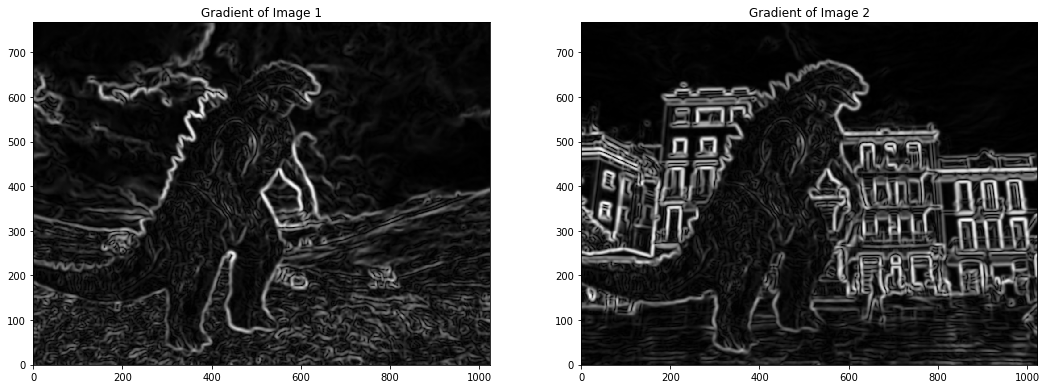

In [11]:
fig, ax = plt.subplots(1,2, figsize=(18., 12.))
ax[0].imshow(normgrad1, origin='lower', cmap='Greys_r')
ax[0].set_title('Gradient of Image 1')
ax[1].imshow(normgrad2, origin='lower', cmap='Greys_r')
ax[1].set_title('Gradient of Image 2')
plt.show()

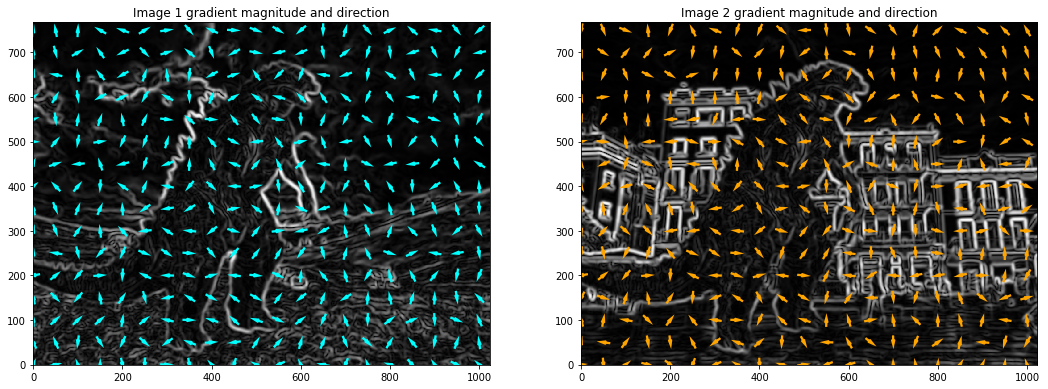

In [12]:
fig, ax = plt.subplots(1,2, figsize=(18., 12.))
ax[0].imshow(normgrad1, origin='lower', cmap='Greys_r')
arrows1=ax[0].quiver(X, Y, ux1, uy1, units='width', color='cyan', pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[0].set_title('Image 1 gradient magnitude and direction')
ax[1].imshow(normgrad2, origin='lower', cmap='Greys_r')
arrows2=ax[1].quiver(X, Y, ux2, uy2, units='width', color='orange',  pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[1].set_title('Image 2 gradient magnitude and direction')
plt.show()

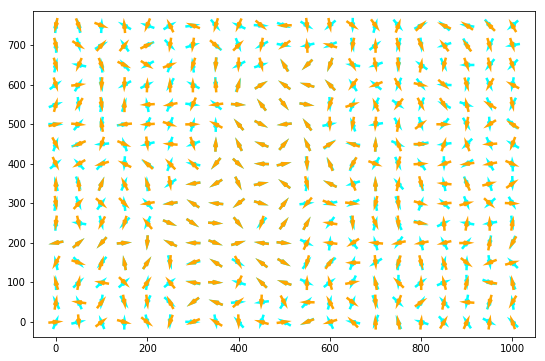

In [13]:
fig, ax = plt.subplots(figsize=(9., 6.))
arrows1=ax.quiver(X, Y, ux1, uy1, units='width', color='cyan',   pivot='middle',  width=0.005, headwidth=2, headlength=4)
arrows2=ax.quiver(X, Y, ux2, uy2, units='width', color='orange',  pivot='middle', width=0.005, headwidth=2, headlength=4)
plt.show()

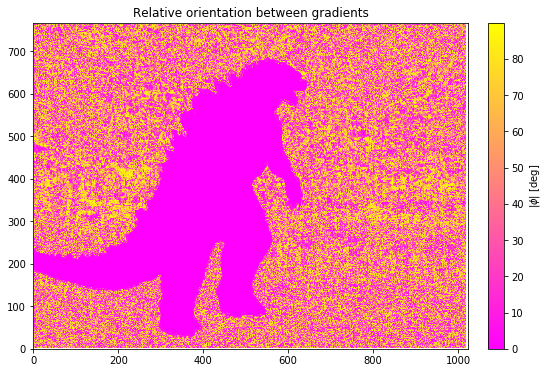

In [14]:
fig, ax = plt.subplots(1,1, figsize=(9., 6.))
im=plt.imshow(np.abs(corrframe)*180.0/np.pi, origin='lower', cmap='spring')
cb1=plt.colorbar(im,fraction=0.046, pad=0.04)
cb1.set_label(r'$|\phi|$ [deg]')
ax.set_title('Relative orientation between gradients')
plt.show()

PRS= 289.96023046649447
AM = 0.44367737


/Users/soler/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/soler/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


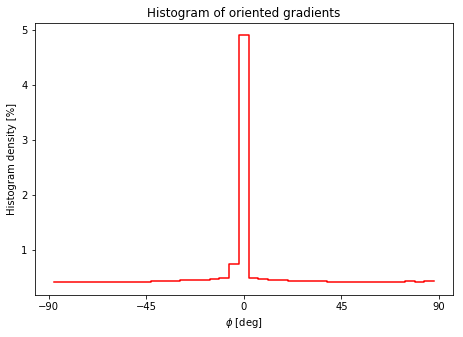

In [15]:
# Computing the histogram of relative orientations
sz=np.shape(corrframe)
hist, bin_edges = np.histogram(corrframe[int(2.*ksz):sz[0],int(2.*ksz):sz[1]]*180.0/np.pi, density=True, range=[-90.,90.], bins=40)
bin_center=0.5*(bin_edges[0:np.size(bin_edges)-1]+bin_edges[1:np.size(bin_edges)])

print('PRS=',HOG_PRS(2.*corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(2.*ksz):sz[1]-int(2.*ksz)])[0])
print('AM =',HOG_AM(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(2.*ksz):sz[1]-int(2.*ksz)]))

# Show the histogram of oriented gradients
fig, ax = plt.subplots(1,1, figsize=(7.5, 5.))
ax.step(bin_center, hist*100, color='red')
ax.set_ylabel('Histogram density [%]')
ax.set_xlabel(r'$\phi$ [deg]')
ax.set_xticks([-90.,-45.,0.,45.,90.])
ax.set_title('Histogram of oriented gradients')
plt.show()

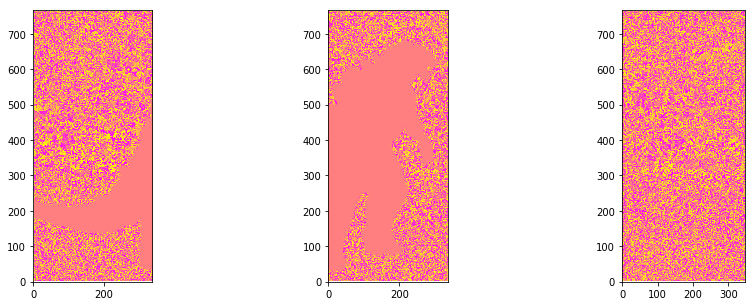

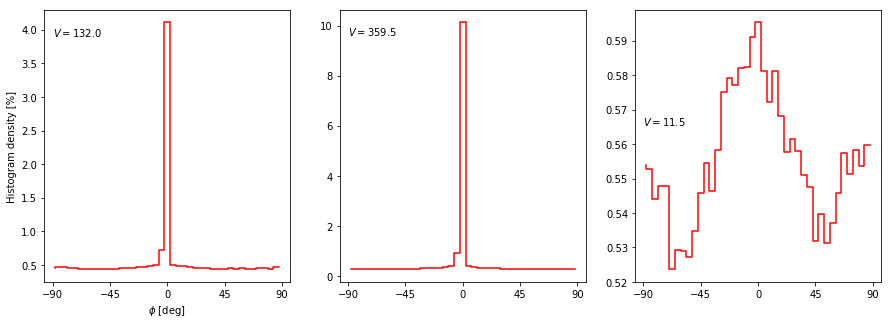

In [19]:
# Computing the histogram of relative orientations for different portions of the images

fig, ax = plt.subplots(1,3, figsize=(15., 5.))
#plt.imshow(corrframe[0:int(0.33*sz[0]),:])
ax[0].imshow(corrframe[:,0:int(0.33*sz[1])], origin='lower', cmap='spring')
ax[1].imshow(corrframe[:,int(0.33*sz[1]):int(0.66*sz[1])], origin='lower', cmap='spring')
ax[2].imshow(corrframe[:,int(0.66*sz[1]):sz[1]-1], origin='lower', cmap='spring')
plt.show()

sz=np.shape(corrframe)
hist1, bin_edges = np.histogram(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(2.*ksz):int(0.33*sz[1])]*180.0/np.pi, density=True, range=[-90.,90.], bins=40)
hist2, bin_edges = np.histogram(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.33*sz[1]):int(0.66*sz[1])]*180.0/np.pi, density=True, range=[-90.,90.], bins=40)
hist3, bin_edges = np.histogram(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.66*sz[1]):sz[1]-int(2.*ksz)]*180.0/np.pi, density=True, range=[-90.,90.], bins=40)
bin_center=0.5*(bin_edges[0:np.size(bin_edges)-1]+bin_edges[1:np.size(bin_edges)])

PRS1=HOG_PRS(2.*corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(2.*ksz):int(0.33*sz[1])])[0]
PRS2=HOG_PRS(2.*corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.33*sz[1]):int(0.66*sz[1])])[0]
PRS3=HOG_PRS(2.*corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.66*sz[1]):sz[1]-int(2.*ksz)])[0]

# In case you want to use the alignment measure (AM) to evaluate the correlation
#print('AM =',HOG_AM(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(2.*ksz):int(0.33*sz[1])]))
#print('AM =',HOG_AM(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.33*sz[1]):int(0.66*sz[1])]))
#print('AM =',HOG_AM(corrframe[int(2.*ksz):sz[0]-int(2.*ksz),int(0.66*sz[1]):sz[1]-int(2.*ksz)]))

# Show the histogram of oriented gradients
fig, ax = plt.subplots(1,3, figsize=(15., 5.))
ax[0].step(bin_center, hist1*100, color='red')
ax[0].set_ylabel('Histogram density [%]')
ax[0].set_xlabel(r'$\phi$ [deg]')
ax[0].set_xticks([-90.,-45.,0.,45.,90.])
ax[0].text(-90., 0.95*np.max(hist1*100),r'$V=$'+str(np.round(PRS1,1)))
ax[1].step(bin_center, hist2*100, color='red')
ax[1].set_xticks([-90.,-45.,0.,45.,90.])
ax[1].text(-90., 0.95*np.max(hist2*100),r'$V=$'+str(np.round(PRS2,1)))
ax[2].step(bin_center, hist3*100, color='red')
ax[2].set_xticks([-90.,-45.,0.,45.,90.])
ax[2].text(-90., 0.95*np.max(hist3*100),r'$V=$'+str(np.round(PRS3,1)))
plt.show()